### Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification
import sys, os
sys.path.append(os.path.abspath(".."))  
from dataset import PACSDataset, VLCSDataset, OfficeHomeDataset
from vit_grqo import ViTGRQO, grqo_loss_from_gradients
from encoder_decoder_vit import VisualDecoder, MultiheadAttn, DecoderAttn
from Visual_query_heads import QueryLosses, GRQO
from transformers import ViTModel, AutoFeatureExtractor

### CONFIG 

In [2]:
import os
from datasets import load_dataset
from PIL import Image

# Your constants
VLCS_ROOT = r"D:\Haseeb\Datasets\VLCS"
VLCS_DOMAINS = ["VOC2007", "LabelMe", "Caltech101", "SUN09"]
VLCS_CLASSES = ["bird", "car", "chair", "dog", "person"]
BATCH_SIZE = 32
NUM_CLASSES = 7
NUM_EPOCHS = 5
LR = 1e-4
TOPK = 24
ALPHA = 2.0
BETA = 0.5
TAU = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# dataset = load_dataset("flwrlabs/pacs", split="train")

# os.makedirs(DATA_ROOT, exist_ok=True)
# for domain in DOMAINS:
#     for cls in CLASSES:
#         os.makedirs(f"{DATA_ROOT}/{domain}/{cls}", exist_ok=True)

# for i, example in enumerate(dataset):
#     domain = example["domain"]  
#     label_idx = example["label"]  
#     label = CLASSES[label_idx]

#     if domain not in DOMAINS:
#         raise ValueError(f"Unexpected domain: {domain}. Expected one of {DOMAINS}")
#     if label not in CLASSES:
#         raise ValueError(f"Unexpected label: {label}. Expected one of {CLASSES}")
    
#     image = example["image"]
#     image.save(f"{DATA_ROOT}/{domain}/{label}/image_{i}.jpg")


### Data

In [3]:
TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

vlcs_data = VLCSDataset(VLCS_ROOT, TRANSFORM, batch_size=32)

ALL_DOMAINS = ["VOC2007", "LabelMe", "Caltech101", "SUN09"]

### Model 

In [4]:
# ViT-Tiny Backbone from Hugging Face ---
vit_encoder = ViTModel.from_pretrained("WinKawaks/vit-tiny-patch16-224")
HIDDEN_DIM = vit_encoder.config.hidden_size  # 192 for ViT-Tiny

# GRQO Hyperparameters ---
NUM_HEADS = 6
DROPOUT = 0.1
NUM_LAYERS = 3
DDROPOUT = 0.1
NUM_TOKENS = 32
TEMPERATURE = 0.1
ALPHA = 2.0
BETA = 0.5
TAU = 1e-3
LAMBDA_GRQO = 1.0
TEACHER_EMA = 0.99
NUM_CLASSES = 5

# GRQO Decoder ---
grqo_model = GRQO(
    Hidden_dim=HIDDEN_DIM,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    num_tokens=NUM_TOKENS,
    ddropout=DDROPOUT,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    temperature=TEMPERATURE,
    alpha=ALPHA,
    beta=BETA,
    tau=TAU,
    lambda_grqo=LAMBDA_GRQO,
    teacher_ema=TEACHER_EMA,
    reward_proxy="taylor"
)

# Full ViTGRQO Model ---
class ViTGRQO(nn.Module):
    def __init__(self, vit_encoder, grqo_model):
        super().__init__()
        self.vit = vit_encoder
        self.grqo = grqo_model

    def forward(self, x, labels=None):
        # Get patch embeddings from HF ViT (exclude CLS token)
        outputs = self.vit(pixel_values=x, output_hidden_states=True)
        patch_tokens = outputs.last_hidden_state[:, 1:, :]  # [B, N, D] skip CLS token
        return self.grqo(patch_tokens, labels)

# Initialize model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Model initialized on {device}")
print(f"Hidden dim: {HIDDEN_DIM}, Num tokens: {NUM_TOKENS}")

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized on cuda
Hidden dim: 192, Num tokens: 32


### training

In [5]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0.0
    total_cls_loss = 0.0
    total_grqo_loss = 0.0
    correct = 0
    total_samples = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output = model(images, labels)
        
        # Extract losses
        loss = output['loss']
        cls_loss = output['cls_loss']
        grqo_loss = output['grqo_loss']
        preds = output['preds']
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item() * images.size(0)
        total_cls_loss += cls_loss.item() * images.size(0)
        total_grqo_loss += grqo_loss.item() * images.size(0)
        correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
        
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}, Loss: {loss.item():.4f}, '
                  f'Cls: {cls_loss.item():.4f}, GRQO: {grqo_loss.item():.4f}')
    
    avg_loss = total_loss / total_samples
    avg_cls_loss = total_cls_loss / total_samples
    avg_grqo_loss = total_grqo_loss / total_samples
    accuracy = correct / total_samples
    
    return avg_loss, avg_cls_loss, avg_grqo_loss, accuracy

### evaluation

In [6]:
def validate(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0

    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        
        # GRQO needs gradients even during validation
        with torch.set_grad_enabled(True):
            output = model(images, labels)
            preds = output['preds']
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    accuracy = correct / total
    return accuracy

### finetuning 

In [7]:
# VLCS LODO Training & Evaluation
ALL_DOMAINS = ["VOC2007", "LabelMe", "Caltech101", "SUN09"]
lodo_results = {}

for LEAVE_OUT in ALL_DOMAINS:
    print(f"\n=== LODO: Leaving out domain '{LEAVE_OUT}' ===")
    TRAIN_DOMAINS = [d for d in ALL_DOMAINS if d != LEAVE_OUT]
    VAL_DOMAIN = LEAVE_OUT

    # Create data loaders
    train_datasets = [vlcs_data.get_dataloader(domain=d, train=True) for d in TRAIN_DOMAINS]
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset([d.dataset for d in train_datasets]),
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = vlcs_data.get_dataloader(domain=VAL_DOMAIN, train=False)

    # Reset model for this split
    model = ViTGRQO(vit_encoder, grqo_model).to(DEVICE)

    FREEZE_VIT = False
    if FREEZE_VIT:
        for param in model.vit.parameters():
            param.requires_grad = False
    
    # Optimizer
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.AdamW(trainable_params, lr=LR, weight_decay=0.01)

    best_val_acc = 0.0
    
    # Training loop
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        
        # Train
        train_loss, train_cls, train_grqo, train_acc = train_epoch(model, train_loader, optimizer, DEVICE)
        
        # Validate  
        val_acc = validate(model, val_loader, DEVICE)
        
        print(f"Train - Loss: {train_loss:.4f}, Cls: {train_cls:.4f}, "
              f"GRQO: {train_grqo:.4f}, Acc: {train_acc:.4f}")
        print(f"Val Acc ({VAL_DOMAIN}): {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
    
    lodo_results[VAL_DOMAIN] = best_val_acc
    print(f"Best Val Acc for {VAL_DOMAIN}: {best_val_acc:.4f}")

# Results Summary
print("\n" + "="*50)
print("VLCS LODO RESULTS SUMMARY")
print("="*50)
for domain, acc in lodo_results.items():
    print(f"{domain:15}: {acc:.4f}")

avg_lodo = sum(lodo_results.values()) / len(lodo_results)
print(f"{'Average':15}: {avg_lodo:.4f}")
print("="*50)


=== LODO: Leaving out domain 'VOC2007' ===

Epoch 1/5
Batch 0, Loss: 1.5299, Cls: 1.4714, GRQO: 0.0584
Batch 50, Loss: 0.4710, Cls: 0.4648, GRQO: 0.0062
Batch 100, Loss: 0.3496, Cls: 0.3451, GRQO: 0.0045
Batch 150, Loss: 0.4508, Cls: 0.4477, GRQO: 0.0031
Train - Loss: 0.5950, Cls: 0.5878, GRQO: 0.0072, Acc: 0.7757
Val Acc (VOC2007): 0.7589

Epoch 2/5
Batch 0, Loss: 0.4811, Cls: 0.4778, GRQO: 0.0033
Batch 50, Loss: 0.3286, Cls: 0.3259, GRQO: 0.0027
Batch 100, Loss: 0.2739, Cls: 0.2712, GRQO: 0.0027
Batch 150, Loss: 0.3462, Cls: 0.3437, GRQO: 0.0024
Train - Loss: 0.4271, Cls: 0.4245, GRQO: 0.0027, Acc: 0.8434
Val Acc (VOC2007): 0.7411

Epoch 3/5
Batch 0, Loss: 0.2981, Cls: 0.2960, GRQO: 0.0021
Batch 50, Loss: 0.5879, Cls: 0.5857, GRQO: 0.0023
Batch 100, Loss: 0.2468, Cls: 0.2447, GRQO: 0.0021
Batch 150, Loss: 0.3118, Cls: 0.3098, GRQO: 0.0020
Train - Loss: 0.3376, Cls: 0.3355, GRQO: 0.0020, Acc: 0.8828
Val Acc (VOC2007): 0.7382

Epoch 4/5
Batch 0, Loss: 0.3477, Cls: 0.3458, GRQO: 0.0019

### Baseline

In [8]:
print("\n=== Leave-One-Domain-Out (LODO) Training & Validation on VLCS ===")

# VLCS domains
ALL_DOMAINS = ["VOC2007", "LabelMe", "Caltech101", "SUN09"]

lodo_results = {}  # store per-domain results

for LEAVE_OUT in ALL_DOMAINS:
    print(f"\n=== LODO: Leaving out {LEAVE_OUT.upper()} for validation ===")
    
    TRAIN_DOMAINS = [d for d in ALL_DOMAINS if d != LEAVE_OUT]
    VAL_DOMAIN = LEAVE_OUT

    # ---- Train loader (concat all train domains) ----
    train_datasets = [vlcs_data.get_dataloader(domain=d, train=True) for d in TRAIN_DOMAINS]
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset([d.dataset for d in train_datasets]),
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    # ---- Validation loader (only leave-out domain) ----
    val_loader = vlcs_data.get_dataloader(domain=VAL_DOMAIN, train=False)

    # ---- Model (reset for each LODO run) ----
    model = ViTForImageClassification.from_pretrained(
        "WinKawaks/vit-tiny-patch16-224",
        num_labels=NUM_CLASSES,        
        ignore_mismatched_sizes=True
    ).to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} (Leave out {VAL_DOMAIN})")

        # ---- Training ----
        model.train()
        running_loss, running_corrects, running_samples = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            logits = outputs.logits
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = logits.argmax(dim=1)
            running_loss += loss.item() * images.size(0)
            running_corrects += (preds == labels).sum().item()
            running_samples += labels.size(0)

        train_loss = running_loss / running_samples
        train_acc = running_corrects / running_samples

        # ---- Validation on held-out domain ----
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                preds = outputs.logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total if total > 0 else 0.0

        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val Acc ({VAL_DOMAIN}): {val_acc:.4f}")

        # Track best validation accuracy
        best_val_acc = max(best_val_acc, val_acc)

    # Save best result for this LODO run
    lodo_results[VAL_DOMAIN] = best_val_acc

# ---------------- Results Summary ----------------
print("\n" + "="*50)
print("LODO RESULTS SUMMARY (VLCS)")
print("="*50)
for domain, acc in lodo_results.items():
    print(f"{domain:15}: {acc:.4f}")

avg_lodo = sum(lodo_results.values()) / len(lodo_results)
print(f"{'Average LODO':15}: {avg_lodo:.4f}")
print("="*50)


=== Leave-One-Domain-Out (LODO) Training & Validation on VLCS ===

=== LODO: Leaving out VOC2007 for validation ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5 (Leave out VOC2007)
Train - Loss: 0.5326, Acc: 0.7997
Val Acc (VOC2007): 0.7692

Epoch 2/5 (Leave out VOC2007)
Train - Loss: 0.2930, Acc: 0.8905
Val Acc (VOC2007): 0.7559

Epoch 3/5 (Leave out VOC2007)
Train - Loss: 0.1667, Acc: 0.9417
Val Acc (VOC2007): 0.7574

Epoch 4/5 (Leave out VOC2007)
Train - Loss: 0.1067, Acc: 0.9619
Val Acc (VOC2007): 0.6997

Epoch 5/5 (Leave out VOC2007)
Train - Loss: 0.0738, Acc: 0.9736
Val Acc (VOC2007): 0.7604

=== LODO: Leaving out LABELME for validation ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5 (Leave out LabelMe)
Train - Loss: 0.4544, Acc: 0.8317
Val Acc (LabelMe): 0.5789

Epoch 2/5 (Leave out LabelMe)
Train - Loss: 0.1934, Acc: 0.9305
Val Acc (LabelMe): 0.6053

Epoch 3/5 (Leave out LabelMe)
Train - Loss: 0.0985, Acc: 0.9672
Val Acc (LabelMe): 0.6203

Epoch 4/5 (Leave out LabelMe)
Train - Loss: 0.0648, Acc: 0.9792
Val Acc (LabelMe): 0.6203

Epoch 5/5 (Leave out LabelMe)
Train - Loss: 0.0641, Acc: 0.9763
Val Acc (LabelMe): 0.6410

=== LODO: Leaving out CALTECH101 for validation ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5 (Leave out Caltech101)
Train - Loss: 0.5747, Acc: 0.7774
Val Acc (Caltech101): 0.9823

Epoch 2/5 (Leave out Caltech101)
Train - Loss: 0.3164, Acc: 0.8843
Val Acc (Caltech101): 0.9505

Epoch 3/5 (Leave out Caltech101)
Train - Loss: 0.1787, Acc: 0.9384
Val Acc (Caltech101): 0.9788

Epoch 4/5 (Leave out Caltech101)
Train - Loss: 0.1196, Acc: 0.9591
Val Acc (Caltech101): 0.9611

Epoch 5/5 (Leave out Caltech101)
Train - Loss: 0.1002, Acc: 0.9670
Val Acc (Caltech101): 0.9576

=== LODO: Leaving out SUN09 for validation ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5 (Leave out SUN09)
Train - Loss: 0.5130, Acc: 0.8051
Val Acc (SUN09): 0.7549

Epoch 2/5 (Leave out SUN09)
Train - Loss: 0.2753, Acc: 0.8983
Val Acc (SUN09): 0.7352

Epoch 3/5 (Leave out SUN09)
Train - Loss: 0.1632, Acc: 0.9421
Val Acc (SUN09): 0.7504

Epoch 4/5 (Leave out SUN09)
Train - Loss: 0.0984, Acc: 0.9679
Val Acc (SUN09): 0.6773

Epoch 5/5 (Leave out SUN09)
Train - Loss: 0.1031, Acc: 0.9659
Val Acc (SUN09): 0.7245

LODO RESULTS SUMMARY (VLCS)
VOC2007        : 0.7692
LabelMe        : 0.6410
Caltech101     : 0.9823
SUN09          : 0.7549
Average LODO   : 0.7869


### Plot

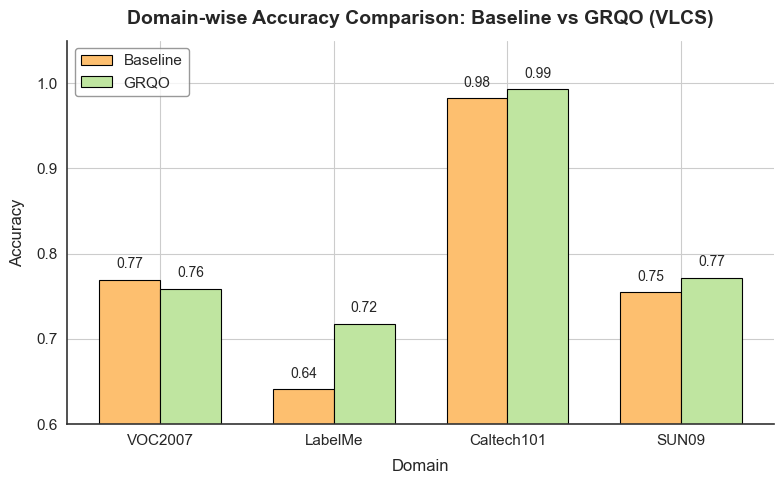

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Use consistent, minimal academic styling
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "figure.figsize": (8, 5),
    "axes.edgecolor": "#333333",
    "axes.linewidth": 1.2
})

# Data
domains = ["VOC2007", "LabelMe", "Caltech101", "SUN09"]
baseline = [0.7692, 0.6410, 0.9823, 0.7549]
grqo = [0.7589, 0.7180, 0.9929, 0.7717]

x = np.arange(len(domains))
width = 0.35

# Elegant contrasting palette (teal vs coral)
colors = sns.color_palette("Spectral", 2)

fig, ax = plt.subplots()

# Bars
bars1 = ax.bar(x - width/2, baseline, width, label='Baseline',
               color=colors[0], edgecolor='black', linewidth=0.8)
bars2 = ax.bar(x + width/2, grqo, width, label='GRQO',
               color=colors[1], edgecolor='black', linewidth=0.8)

# Axis labels and title
ax.set_ylabel('Accuracy', labelpad=8)
ax.set_xlabel('Domain', labelpad=8)
ax.set_title('Domain-wise Accuracy Comparison: Baseline vs GRQO (VLCS)', 
             pad=12, fontweight='semibold')
ax.set_xticks(x)
ax.set_xticklabels(domains)
ax.set_ylim(0.60, 1.05)

# Add accuracy labels
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f"{height:.2f}", ha='center', va='bottom', fontsize=10, fontweight='medium')

annotate_bars(bars1)
annotate_bars(bars2)

# Legend
ax.legend(frameon=True, fancybox=True, facecolor='white',
          edgecolor='gray', loc='upper left')

# Final visual cleanup
sns.despine(left=False, bottom=False)
plt.tight_layout()
plt.show()
